# Assignment 2: Training the Fully Recurrent Network

*Author:* Thomas Adler

*Copyright statement:* This  material,  no  matter  whether  in  printed  or  electronic  form,  may  be  used  for  personal  and non-commercial educational use only.  Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.


## Exercise 1: Data generation

There are two classes, both occurring with probability 0.5. There is one input unit. Only the first sequence element conveys relevant information about the class. Sequence elements at positions $t > 1$ stem from a Gaussian with mean zero and variance 0.2. The first sequence element is 1.0 (-1.0) for class 1 (2). Target at sequence end is 1.0 (0.0) for class 1 (2)

Write a function `generate_data` that takes an integer `T` as argument which represents the sequence length. Seed the `numpy` random generator with the number `0xDEADBEEF`. Implement the [Python3 generator](https://docs.python.org/3/glossary.html#term-generator) pattern and produce data in the way described above. The input sequences should have the shape `(T, 1)` and the target values should have the shape `(1,)`.

In [1]:
%matplotlib inline
import numpy as np
from scipy.special import expit as sigmoid
import matplotlib.pyplot as plt

class FullyRecurrentNetwork(object):
    def __init__(self, D, I, K):
        self.W = np.random.uniform(-0.01, 0.01, (I, D))
        self.R = np.random.uniform(-0.01, 0.01, (I, I))
        self.V = np.random.uniform(-0.01, 0.01, (K, I))
    
    def forward(self, x, y):
        # helper function for numerically stable loss
        def f(z):
            return np.log1p(np.exp(-np.absolute(z))) + np.maximum(0, z)
        
        # infer dims
        T, D = x.shape
        K, I = self.V.shape

        # init result arrays
        self.x = x
        self.y = y
        self.a = np.zeros((T, I))

        # iterate forward in time 
        # trick: access model.a[-1] in first iteration
        for t in range(T):
            self.a[t] = np.tanh(self.W @ x[t] + self.R @ self.a[t-1])
            
        self.z = model.V @ self.a[t]
        return y * f(-self.z) + (1-y) * f(self.z)

T, D, I, K = 10, 3, 5, 1
model = FullyRecurrentNetwork(D, I, K)
model.forward(np.random.uniform(-1, 1, (T, D)), 1)


rng = np.random.default_rng(0xDEADBEEF)

def generate_data(T):
    ########## YOUR SOLUTION HERE ##########
    
    # initialize random number generator
    
    while True:
        
        # create array for sequence
        x = np.zeros((T,1))
        x[0] = rng.choice([1.0, -1.0], size=1, p=[0.5,0.5]) #1,-1
        x[1:T] = rng.normal(loc=0.0, scale=np.sqrt(0.2), size=(T-1,1))

        # create target values depending on class
        if x[0] == 1.0:
            y = np.array([1]) #1
        else:
            y = np.array([0]) #0

        yield x,y
        
data = generate_data(2)

## Exercise 2: Gradients for the network parameters
Compute gradients of the total loss 
$$
L = \sum_{t=1}^T L(t), \quad \text{where} \quad L(t) = L(z(t), y(t))
$$
w.r.t. the weights of the fully recurrent network. To this end, find the derivative of the loss w.r.t. the logits and hidden pre-activations first, i.e., 
$$
\psi^\top(t) = \frac{\partial L}{\partial z(t)} \quad \text{and} \quad \delta^\top(t) = \frac{\partial L}{\partial s(t)}.
$$
With the help of these intermediate results you should be able to compute the gradients w.r.t. the weights, i.e., $\nabla_W L, \nabla_R L, \nabla_V L$. 

*Hint: Take a look at the computational graph from the previous assignment to see the functional dependencies.*

*Remark: Although we only have one label at the end of the sequence, we consider the more general case of evaluating a loss at every time step in this exercise (many-to-many mapping).*

########## YOUR SOLUTION HERE ##########

$$
\begin{align*}
\psi^\top(t) &= \frac{\partial L}{\partial z^{T}(t)}
= \sum^{T}_{t=1} \frac{\partial L(t)}{\partial z^{T}(t)}
=\sum^{T}_{t=1} \frac{\partial L(\sigma(z(t)),y(t))}{\partial z^{T}(t)} 
= \sum^{T}_{t=1} (\hat y(t) - y(t))^{T} \\ 
& \Rightarrow \text{ To derive the derivative above I refer to assignment 1, where we already showed that} 
\\\\
\delta^\top(t) &= \frac{\partial L}{\partial s^{T}(t)}
= \sum^{T}_{t=1} \frac{\partial L(t)}{\partial s^{T}(t)} 
= \sum^{T}_{t=1} (\frac{\partial L(t+1)}{\partial z(t+1)} \frac{\partial z(t+1)}{\partial a(t+1)} \frac{\partial a(t+1)}{\partial s(t+1)} \frac{\partial s(t+1)}{\partial a(t)} + \frac{\partial L(t)}{\partial z(t)} \frac{\partial z(t)}{\partial a(t)}) \frac{\partial a(t)}{\partial s(t)}\\
&= \sum^{T}_{t=1} (\delta^\top(t+1) \frac{\partial s(t+1)}{\partial a(t)} + \frac{\partial L(t)}{\partial z(t)} \frac{\partial z(t)}{\partial a(t)}) \frac{\partial a(t)}{\partial s(t)}\\
&= \sum^{T}_{t=1} (\delta^\top(t+1) \cdot R^{T} +  \psi^\top(t) \cdot V) \cdot \text{diag}(1-\tanh^{2}s(t))
\\\\
\frac{\partial L}{\partial v_{ki}} &= \sum^{T}_{t=1} \frac{\partial L(t)}{\partial v_{ki}} 
= \sum^{T}_{t=1} \frac{\partial L(t)}{\partial z(t)} \frac{\partial z(t)}{\partial v_{ki}}
= \sum^{T}_{t=1} \frac{\partial L(t)}{\partial z_{k}(t)} \frac{\partial z_{k}(t)}{\partial v_{ki}}
= \sum^{T}_{t=1} \psi_{k}(t)\tanh(s_{i}(t))\\
& \Rightarrow \text{ Can be brought into outer product representation:} \\
& \frac{\partial L}{\partial V} = \sum^{T}_{t=1} \psi(t)\tanh(s(t))^{T}
\\\\
\frac{\partial L}{\partial w_{id}} &= \sum^{T}_{t=1} \frac{\partial L(t)}{\partial w_{id}} 
= \sum^{T}_{t=1} \frac{\partial L(t)}{\partial s(t)}\frac{\partial s(t)}{\partial w_{id}}
= \sum^{T}_{t=1} \frac{\partial L(t)}{\partial s_{i}(t)}\frac{\partial s_{i}(t)}{\partial w_{id}}
= \sum^{T}_{t=1} \delta_{i}(t)x_{d}(t)\\
& \Rightarrow \text{ Can be brought into outer product representation:} \\
& \frac{\partial L}{\partial W} = \sum^{T}_{t=1} \delta(t)x(t)^{T}
\\\\
\frac{\partial L}{\partial r_{ij}} &= \sum^{T}_{t=1} \frac{\partial L(t)}{\partial r_{ij}} 
= \sum^{T}_{t=1} \frac{\partial L(t)}{\partial s(t)}\frac{\partial s(t)}{\partial r_{ij}}
= \sum^{T}_{t=1} \frac{\partial L(t)}{\partial s_{i}(t)}\frac{\partial s_{i}(t)}{\partial r_{ij}}
= \sum^{T}_{t=1} \delta_{i}(t)a_{j}(t-1)\\
& \Rightarrow \text{ Can be brought into outer product representation:} \\
& \frac{\partial L}{\partial R} = \sum^{T}_{t=1} \delta(t)a(t-1)^{T}
\\\\
\end{align*}
$$

### Exercise 3: The backward pass
Write a function `backward` that takes a model `self` as argument. The function should compute the gradients of the loss with respect to all model parameters and store them to `self.dW`, `self.dR`, `self.dV`, respectively. 

In [2]:
def backward(self):
    
    ########## YOUR SOLUTION HERE ##########   
    
    T, D = self.x.shape
    K, I = self.V.shape
    
    self.dW = np.zeros(self.W.shape)
    self.dR = np.zeros(self.R.shape)
    self.dV = np.zeros(self.V.shape)
    
    delta = np.zeros((T+1, I, 1))
    psi = np.zeros((T, K, 1))
    psi[-1] = np.reshape((sigmoid(self.z) - self.y),(-1,1))
    
    for t in range(T-1,-1,-1):
        delta[t] = ((delta[t+1].T @ self.R + psi[t].T @ self.V) @ np.diag(1- self.a[t]**2)).T
        self.dV += psi[t] @ np.reshape(self.a[t],(1,-1))
        self.dW += delta[t] @ np.reshape(self.x[t], (1,-1))
        self.dR += delta[t] @ np.reshape(self.a[t-1], (1,-1))
        
FullyRecurrentNetwork.backward = backward
model.backward()

## Exercise 4: Gradient checking
Write a function `grad_check` that takes a model `self`, a float `eps` and another float `thresh` as arguments and computes the numerical gradients of the model parameters according to the approximation
$$
f'(x) \approx \frac{f(x + \varepsilon) - f(x - \varepsilon)}{2 \varepsilon}.
$$
If any of the analytical gradients are farther than `thresh` away from the numerical gradients the function should throw an error. 

In [3]:
def grad_check(self, eps, thresh):
    ########## YOUR SOLUTION HERE ##########
    
    T, D = self.x.shape
    K, I = self.V.shape
    
    def num_grad(parameter,eps):

        rows, cols = parameter.shape
        num_grad_matrix = np.zeros((rows,cols))
        
        for row in range(rows):
            for col in range(cols):
                # plus
                parameter[row][col] += eps
                L_plus = self.forward(self.x, self.y)

                # minus
                parameter[row][col] -= 2*eps
                L_minus = self.forward(self.x, self.y)
                parameter[row][col] += eps

                # num grad
                num_grad_matrix[row][col] = (L_plus - L_minus)/(2*eps)
                
        return num_grad_matrix
    
    num_dW = num_grad(self.W, eps)
    num_dV = num_grad(self.V, eps)
    num_dR = num_grad(self.R, eps)
    
    dW_check = np.all(np.abs(num_dW - self.dW) <= thresh)
    dV_check = np.all(np.abs(num_dV - self.dV) <= thresh) 
    dR_check = np.all(np.abs(num_dR - self.dR) <= thresh)
    
    return dW_check and dV_check and dR_check

FullyRecurrentNetwork.grad_check = grad_check
model.grad_check(1e-7, 1e-7)

True

## Exercise 5: Parameter update

Write a function `update` that takes a model `self` and a float argument `eta`, which represents the learning rate. The method should implement the gradient descent update rule $\theta \gets \theta - \eta \nabla_{\theta}L$ for all model parameters $\theta$.

In [4]:
def update(self, eta):
    ########## YOUR SOLUTION HERE ##########

    self.W = self.W - eta * self.dW
    self.V = self.V - eta * self.dV
    self.R = self.R - eta * self.dR

FullyRecurrentNetwork.update = update
model.update(0.001)

## Exercise 6: Network training

Train the fully recurrent network with 32 hidden units. Start with input sequences of length one and tune the learning rate and the number of update steps. Then increase the sequence length by one and tune the hyperparameters again. What is the maximal sequence length for which the fully recurrent network can achieve a performance that is better than random? Visualize your results. 

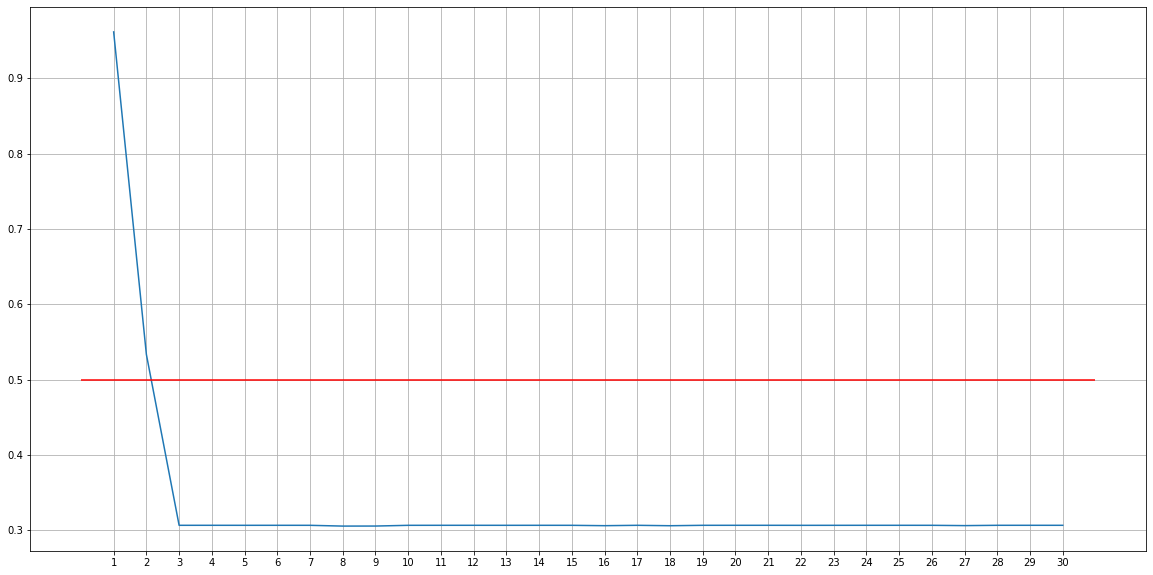

In [5]:
########## YOUR SOLUTION HERE ##########    
D, I, K = 1, 32, 1

results = dict()

T_max = 30

for T in range(1,T_max+1):
    
    model = FullyRecurrentNetwork(D, I, K) 
    
    updates = 200
    lr = 1
    
    loss = []
    
    i = 1
    for x,y in generate_data(T):

        cur_loss = model.forward(x, y)
        loss.append(cur_loss)
        
        model.backward()

        model.update(lr)

        if i == updates:
            break
        i += 1
        
    results[T] = loss
    

# get the sequence lengths 
sequence_lengths = list(results.keys())
# calculate mean loss
mean_losses = 1 - np.mean(np.array(list(results.values())), axis=1) 

# make nice plot
plt.figure(figsize=(20,10))
plt.plot(sequence_lengths, mean_losses)
plt.xticks(sequence_lengths)
plt.hlines(0.5, 0,31, color="red") # indicates where loss is worse than random
plt.grid(True)
plt.show()

## Exercise 7: The Vanishing Gradient Problem

Analyze why the network is incapable of learning long-term dependencies. Show that $\|\frac{\partial a(T)}{\partial a(1)}\|_2 \leq \|R\|_2^{T-1}$ , where $\|\cdot\|_2$ is the spectral norm, and discuss how that affects the propagation of error signals through the time dimension of the network. 

*Hint: Use the fact that the spectral norm is submultiplicative for square matrices, i.e. $\|AB\|_2 \leq \|A\|_2\|B\|_2$ if $A$ and $B$ are both square.*

########## YOUR SOLUTION HERE ##########

We need to show that the network looses information when backpropagating it through time. This is done by taking a closer look at $\delta$ in the gradients. We see that inside the $\delta$ we always have $\frac{\partial a(t+1)}{\partial a(t)}$ and in fact we alwas have in every $\delta (t)$ the $\delta (t+1) inside$. This means in a very nested way the $\delta (1)$ is connected to the $\delta (T)$. Therefore, the derivative $\frac{\partial a(T)}{\partial a(1)}$ is hidden in there and of great importance.

The Proof:

$
\begin{align*}
 \frac{\partial a(T)}{\partial a(1)} &= \frac{\partial a(T)}{\partial a(T-(T-1))} \\
 &= R^{T-1} \cdot (\Pi^{T-2}_{i=0} diag(f'(s(T-i)))) &\text{, with f'(.) being derivative of activation function} \\
 & \Rightarrow \text{both terms are square matrices}
\end{align*}
$

Now since we have calulated the result we are interested what the spectral norm of this gradient is. Since it would be nice to know if we can find some bounds for the underlying matrix multiplication.

$
\begin{align*}
\| \frac{\partial a(T)}{\partial a(1)} \|_2 &= \| R^{T-1} \cdot (\Pi^{T-2}_{i=0} diag(f'(s(T-i)))) \|_2\\
& \leq \| R^{T-1}\|_2 \cdot \|(\Pi^{T-2}_{i=0} diag(f'(s(T-i)))) \|_2 \\
& \leq \| R^{T-1}\|_2 \cdot (\Pi^{T-2}_{i=0} \|diag(f'(s(T-i))) \|_2 )\\
(\text{since the derivative of tanh is always}\leq 1) &\leq \| R^{T-1}\|_2 \cdot k & \text{, with k being some scalar smaller equal than one} \\
&\leq \| R^{T-1}\|_2 \\
&\leq \| R\|_2^{T-1}
\end{align*}
$

So we can see that the upper bound for the derivative means is $\| R\|_2^{T-1}$. The problem is that the spectral norm is taken to the power of $T-1$ , which can lead to three scenarios: <br>
* $\| R\|_2 \leq 1 \Rightarrow$ derivative will decrease even more $\Rightarrow$ Vanishing Gradient
* $\| R\|_2 = 1 \Rightarrow$ derivative will stay stable 
* $\| R\|_2 \geq 1 \Rightarrow$ derivative will increase even more $\Rightarrow$ Exploding Gradient

Since in practice $\| R\|_2 = 1$ will never really happen if not enforced, this will lead to unstable gradients.
These unstable gradients are the reason why the network is incapable of learning long-term dependencies